In [2]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

## Modeling

In [3]:
features = [
  'asst_tot_quantile_values',
 'financial_leverage_quantile_values',
 'profitability_ratio_quantile_values',
 # 'net_income_growth_quantile_values',
 'quick_ratio_v2_quantile_values',
 # 'sales_growth_quantile_values',
 'cash_assets_ratio_quantile_values',
 'dscr_quantile_values',
    # 'ebitda',
    # 'is_first_occurrence'
]


In [4]:
modeling_df = pd.read_csv('../data/train.csv')
modeling_df.shape

(1023552, 44)

In [5]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [6]:
modeling_df.sort_values('stmt_date', inplace=True)

In [7]:
# modeling_df[~modeling_df.index.isin(modeling_df.dropna().index)]['default'].value_counts()

In [8]:
# ### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()

In [9]:
train_idx = [2007]
test_idx = [2008]

In [10]:
train_df = modeling_df[modeling_df['stmt_date'].dt.year.isin(train_idx)].copy()
test_df = modeling_df[modeling_df['stmt_date'].dt.year.isin(test_idx)].copy()


In [11]:
from harness_functions import pre_process

In [12]:
# ??pre_process

In [13]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)
    
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {}
}

In [14]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile


In [15]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile


In [16]:
quantile_features = [
  'asst_tot_quantile',
 'financial_leverage_quantile',
 'profitability_ratio_quantile',
 'net_income_growth_quantile',
 'quick_ratio_v2_quantile',
 'sales_growth_quantile',
 'cash_assets_ratio_quantile',
 'dscr_quantile',
    # 'ebitda',
    # 'is_first_occurrence'
]


In [17]:
train_df.shape, train_data_proc.shape

((144528, 55), (144528, 72))

In [18]:
test_data_proc[features].tail(3)

,asst_tot_quantile_values,financial_leverage_quantile_values,profitability_ratio_quantile_values,quick_ratio_v2_quantile_values,cash_assets_ratio_quantile_values,dscr_quantile_values
957945,0.010031,0.011190,0.004129,0.003460,0.008651,0.018339
957953,0.008993,0.011190,0.007171,0.004151,0.010377,0.018339
957957,0.007612,0.007092,0.005089,0.006918,0.007610,0.002076


In [19]:
formula = 'default ~ '+' + '.join(features)
formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [20]:
model = smf.logit(formula, data = train_data_proc) 
logit_model_sm = model.fit()
print(logit_model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.042135
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               144528
Model:                          Logit   Df Residuals:                   144521
Method:                           MLE   Df Model:                            6
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.1448
Time:                        18:59:37   Log-Likelihood:                -6089.7
converged:                       True   LL-Null:                       -7120.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -7.9252      0.195

In [31]:
print(logit_model_sm.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
asst_tot_quantile_values                0.8790      0.128      6.871      0.000       0.628       1.130
financial_leverage_quantile_values      0.0528      0.005     11.462      0.000       0.044       0.062
profitability_ratio_quantile_values     0.0789      0.005     16.079      0.000       0.069       0.089
quick_ratio_v2_quantile_values          0.5680      0.061      9.313      0.000       0.448       0.688
cash_assets_ratio_quantile_values       0.6509      0.092      7.103      0.000       0.471       0.830
dscr_quantile_values                    0.2652      0.017     15.922      0.000       0.233       0.298


In [30]:
predictions = test_data_proc[['default']].copy()
predictions['predicted_probability'] = logit_model_sm.predict(test_data_proc)
# predictions.dropna(inplace=True)
# predictions.head()
metrics.roc_auc_score(y_score=predictions['predicted_probability'], y_true=predictions['default'])

np.float64(0.7670578557325336)

In [23]:
predictions['predicted_probability'].describe()

count    161863.000000
mean          0.010112
std           0.036104
min           0.000882
25%           0.003644
50%           0.005430
75%           0.008258
max           0.951933
Name: predicted_probability, dtype: float64

In [24]:
predictions['predicted_probability'].min()

np.float64(0.0008822566227836952)

In [25]:
predictions['default'].mean()

np.float64(0.012065759314976245)

In [26]:
cal_model = CalibratedClassifierCV

0.9138909500513938 0.9519329789442526


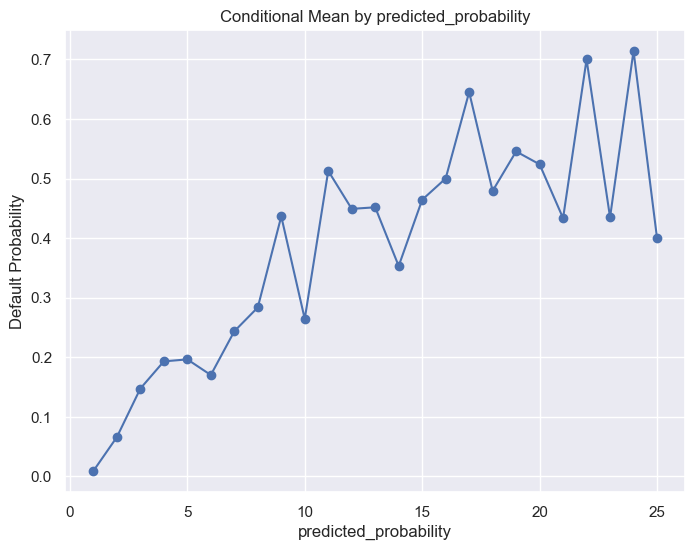

In [27]:
field = 'predicted_probability'
# custom_bins = [0,.10,.11,.12,.13,.14,.19]
cut, bins = pd.cut(predictions['predicted_probability'], bins=25, labels=False, retbins=True, duplicates = 'drop')
cut+=1# Adding 1 to make quantiles start from 1
default_prob_values = predictions.groupby(cut)[['default']].mean()
# print(bins)
print(bins[-2],bins[-1])
plt.figure(figsize=(8, 6))
plt.plot(default_prob_values.index, default_prob_values.default, marker='o', linestyle='-', color='b')
plt.title(f'Conditional Mean by {field}')
plt.xlabel(field)
plt.ylabel('Default Probability')
plt.grid(True)
plt.show()

In [28]:
predictions['predicted_probability'].min()

np.float64(0.0008822566227836952)

In [78]:
metrics.roc_auc_score(y_score=predictions['predicted_probability'], y_true=predictions['default'])

np.float64(0.757565672740776)

<Axes: xlabel='predicted_probability', ylabel='Count'>

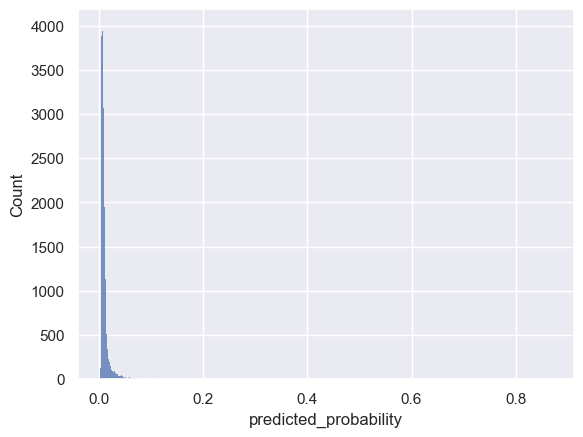

In [79]:
sns.histplot(predictions['predicted_probability'])

ROC AUC 0.757565672740776


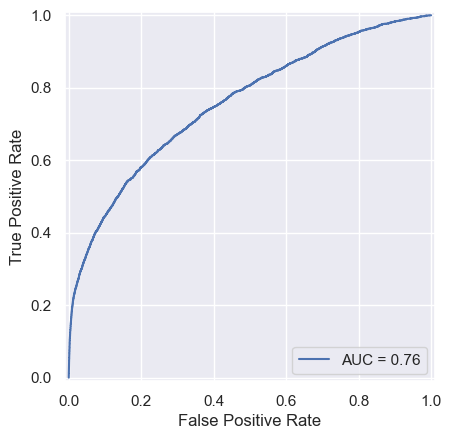

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['default'], predictions['predicted_probability'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

## Walk forward

In [5]:
def predictor(new_df, model):
    predictions = model.predict(new_df)
    return(predictions)

In [54]:
# def preprocessor(df, preproc_params = {}, new = True):

#     quantiles = preproc_params['quantiles']
    
#     to_quantile_features = ['asst_tot',
#                  'financial_leverage',
#                  'profitability_ratio',
#                  'profit',
#                  # 'net_income_growth',
#                  'quick_ratio_v2',
#                  # 'sales_growth',
#                  'cash_assets_ratio',
#                  'dscr']

#     feature_names = []
    
#     for feature in to_quantile_features:
#         if new:
#             cut, bins = pd.qcut(df[feature], q=quantiles, retbins=True,labels=False, duplicates='drop')
            
#             prob_values = df.groupby(cut)[['default']].mean()

#             feature_name = f'{feature}_quantile_value'
#             feature_names.append(feature_name)
            
#             df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']
#             preproc_params['quantile_bins'][feature] = bins
            
#         else:
#             if feature not in preproc_params['quantile_bins']:
#                 raise Exception("Error bins haven't been fitted")
#             bins = preproc_params['quantile_bins'][feature]
            
#             cut = pd.cut(df[feature], bins=bins, labels=False, include_lowest=True)
#             prob_values = df.groupby(cut)[['default']].mean()

#             feature_name = f'{feature}_quantile_value'
#             feature_names.append(feature_name)
            
#             df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']

#     preproc_params['features'] = feature_names
    
#     return(df, preproc_params)

In [3]:
def estimator(df, fitting_algo, est_params = {}):
    
    my_formula = est_params['formula']
    model = fitting_algo(my_formula, data = df) 
    fitted_model = model.fit(disp=False)
    
    return(fitted_model)

In [4]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [81]:
def walk_forward_harness(df, preprocessor, estimator, predictor, 
                         start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {}
    }
    
    df[date_col] = pd.to_datetime(df[date_col])
    walk_range = df[date_col].dt.year.unique()
    
    print(walk_range)
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print(train_idx)
        print(test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        print(train_data_proc[features].tail(3))
        print(test_data_proc[features].tail(3))
        
        
        
        algo_params = {'formula': 'default ~ '+' + '.join(features)}
        
        algo = smf.logit
    
        trained_model = estimator(train_data_proc, algo, algo_params)
        prediction = predictor(test_data_proc, trained_model)
        print(prediction)
        
        labels += list(test_data['default'].values)
        predictions += list(prediction.values)
        
        
        group_list += test_idx
        
        try:
            preds = pd.DataFrame([labels,predictions,group_list]).T
            preds.columns = ['label','prediction','group']
            # preds = preds.dropna()
            score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
            print(score)
            
        except Exception as e:
            print(F'Error scoring {e}')
            score = np.nan

        
        stats_list.append(score)
        model_list.append(trained_model)
        

        # progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [82]:
modeling_df = pd.read_csv('../data/train.csv')
modeling_df.shape

(1023552, 44)

In [83]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [84]:
### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()
modeling_df.sort_values('stmt_date', inplace=True)

In [85]:
features_needed = ['id',
                     'stmt_date',
                     # 'HQ_city',
                     # 'legal_struct',
                     # 'ateco_sector',
                     'def_date',
                     # 'fs_year',
                     # 'asst_intang_fixed',
                     # 'asst_tang_fixed',
                     # 'asst_fixed_fin',
                     # 'asst_current',
                     'AR',
                     'cash_and_equiv',
                     'asst_tot',
                     # 'eqty_tot',
                     # 'eqty_corp_family_tot',
                     # 'liab_lt',
                     # 'liab_lt_emp',
                     # 'debt_bank_st',
                     # 'debt_bank_lt',
                     # 'debt_fin_st',
                     # 'debt_fin_lt',
                     # 'AP_st',
                     # 'AP_lt',
                     'debt_st',
                     'debt_lt',
                     'rev_operating',
                     # 'COGS',
                     'prof_operations',
                     # 'goodwill',
                     # 'inc_financing',
                     'exp_financing',
                     # 'prof_financing',
                     # 'inc_extraord',
                     # 'taxes',
                     'profit',
                     # 'days_rec',
                     'ebitda',
                     # 'roa',
                     # 'roe',
                     # 'wc_net',
                     # 'margin_fin',
                     # 'cf_operations'
                  ]

In [86]:
modeling_df = modeling_df[features_needed]

In [87]:
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [88]:
from harness_functions import pre_process

In [89]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           preprocessor = pre_process, 
                                                           estimator = estimator, 
                                                           predictor = predictor, 
                                                           date_col = 'stmt_date',
                                                           start = 1, 
                                                           step_size = 1)

NameError: name 'estimator' is not defined

In [74]:
predictions.isna().sum()

label         0
prediction    0
group         0
dtype: int64

In [75]:
predictions = predictions.dropna()

ROC AUC 0.48965677180506306


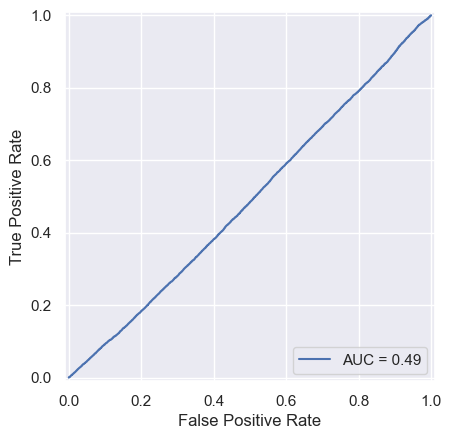

In [76]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

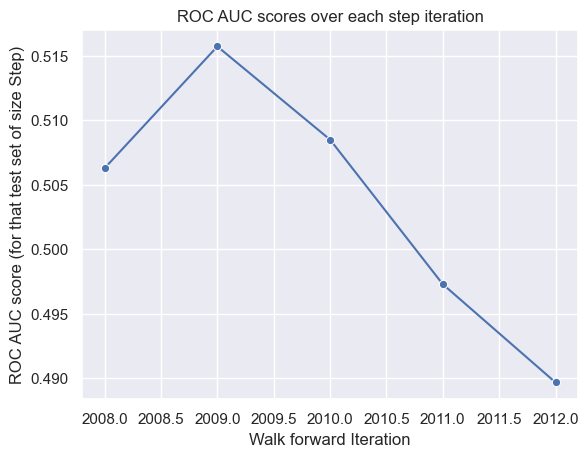

In [77]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [72]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

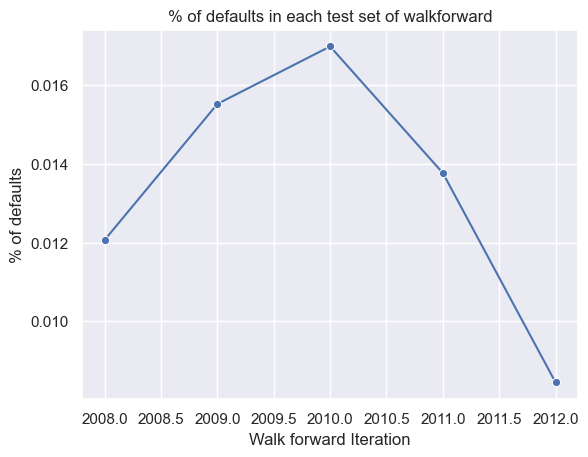

In [73]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')